In [50]:
!nvcc --version
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-9e1as6ie
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-9e1as6ie
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 0a71d56e5dce3ff1f0dd2c47c29367629262f527
  Preparing metadata (setup.py) ... done
The nvcc_plugin extension is already loaded. To reload it, use:
  %reload_ext nvcc_plugin


In [51]:
!/usr/local/cuda/bin/nvcc --version
#!pip install --upgrade git+https://github.com/frehseg/nvcc4jupyter.git
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin
!cuda-install-samples-11.2.sh ~ && cd /root/NVIDIA_CUDA-11.2_Samples/

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-gawv6jo9
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-gawv6jo9
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 0a71d56e5dce3ff1f0dd2c47c29367629262f527
  Preparing metadata (setup.py) ... done
The nvcc_plugin extension is already loaded. To reload it, use:
  %reload_ext nvcc_plugin
/bin/bash: line 1: cuda-install-samples-11.2.sh: command not found


In [52]:
%%cuda --name my_curand.cu
#include <iostream>
#include <cstdlib>
#include <ctime>
#include <cuda_runtime.h>
#include <cublas_v2.h>
#include <chrono>

#define TILE_SIZE 32

__global__ void matrixMultiplicationKernel(const double *A, const double *B, double *C, const int N) {
    int col = threadIdx.x + blockIdx.x * blockDim.x;
    int row = threadIdx.y + blockIdx.y * blockDim.y;

    if (row < N && col < N) {
        for (int i = 0; i < N; ++i) {
            C[row * N + col] += A[row * N + i] * B[i * N + col];
        }
    }
}

void fillMatrixRandomly(double *matrix, int rows, int cols) {
    srand(time(NULL));
    for (int i = 0; i < rows * cols; ++i) {
        matrix[i] = static_cast<double>(rand()) / RAND_MAX;
    }
}

void printMatrix(const double *matrix, int rows, int cols) {
    for (int i = 0; i < rows; ++i) {
        for (int j = 0; j < cols; ++j) {
            std::cout << matrix[i * rows + j] << " ";
        }
        std::cout << std::endl;
    }
    std::cout << std::endl;
}

void printMatrixForward(const double *matrix, int rows, int cols) {
    for (int i = 0; i < rows; ++i) {
        for (int j = 0; j < cols; ++j) {
            printf("%f ", matrix[i * rows + j]);
        }
        printf("\n");
    }
    printf("\n");
}

void matrixMultiplicationCPU(const double *A, const double *B, double *C, const int N) {
    for (int i = 0; i < N; ++i) {
        for (int j = 0; j < N; ++j) {
            C[i * N + j] = 0.0;
            for (int k = 0; k < N; ++k)
                C[i * N + j] += A[i * N + k] * B[k * N + j];
        }
    }
}

int main() {
    int N = 3000;  // Задайте размер матрицы
    int numElements = N * N;
    double *h_A = new double[numElements];
    double *h_B = new double[numElements];
    double *h_C_GPU = new double[numElements];
    double *h_C_CPU = new double[numElements];

    fillMatrixRandomly(h_A, N, N);
    fillMatrixRandomly(h_B, N, N);

    std::cout << "Matrix A:" << std::endl;
    printMatrixForward(h_A, 5, 5);
    std::cout << "Matrix B:" << std::endl;
    printMatrixForward(h_B, 5, 5);

    double *d_A, *d_B, *d_C;
    cudaMalloc(&d_A, numElements * sizeof(double));
    cudaMalloc(&d_B, numElements * sizeof(double));
    cudaMalloc(&d_C, numElements * sizeof(double));

    cudaMemcpy(d_A, h_A, numElements * sizeof(double), cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, h_B, numElements * sizeof(double), cudaMemcpyHostToDevice);

    // GPU Matrix Multiplication
    dim3 threadsPerBlock(TILE_SIZE, TILE_SIZE);
    dim3 blocksPerGrid((N + TILE_SIZE - 1) / TILE_SIZE, (N + TILE_SIZE - 1) / TILE_SIZE);

    auto start_gpu = std::chrono::high_resolution_clock::now();
    matrixMultiplicationKernel<<<blocksPerGrid, threadsPerBlock>>>(d_A, d_B, d_C, N);
    cudaDeviceSynchronize();
    auto end_gpu = std::chrono::high_resolution_clock::now();
    std::chrono::duration<double> gpu_time = end_gpu - start_gpu;

    cudaMemcpy(h_C_GPU, d_C, numElements * sizeof(double), cudaMemcpyDeviceToHost);

    std::cout << "\nMatrix C (GPU):" << std::endl;
    printMatrixForward(h_C_GPU, 5, 5);

    // CPU Matrix Multiplication
    auto start_cpu = std::chrono::high_resolution_clock::now();
    matrixMultiplicationCPU(h_A, h_B, h_C_CPU, N);
    auto end_cpu = std::chrono::high_resolution_clock::now();
    std::chrono::duration<double> cpu_time = end_cpu - start_cpu;

    std::cout << "\nMatrix C (CPU):" << std::endl;
    printMatrixForward(h_C_CPU, 5, 5);

    // Compare results
    double error = 0.0;
    for (int i = 0; i < numElements; ++i) {
        error += std::abs(h_C_GPU[i] - h_C_CPU[i]);
    }

    std::cout << "\nError = " << error << std::endl;
    std::cout << "\nN = " << N << std::endl;
    std::cout << "\nGPU mul time = " << gpu_time.count() << " seconds" << std::endl;
    std::cout << "\nCPU mul time = " << cpu_time.count() << " seconds" << std::endl;

    delete[] h_A;
    delete[] h_B;
    delete[] h_C_GPU;
    delete[] h_C_CPU;

    cudaFree(d_A);
    cudaFree(d_B);
    cudaFree(d_C);

    return 0;
}


'File written in /content/src/my_curand.cu'

In [53]:
!nvcc -o /content/src/my_curand /content/src/my_curand.cu -lcurand -lcublas

In [54]:
!/content/src/my_curand

Matrix A:
0.618533 0.561983 0.042267 0.593280 0.457834 
0.237310 0.848155 0.006550 0.611795 0.876911 
0.987962 0.683411 0.171027 0.707056 0.339619 
0.449062 0.473236 0.141043 0.025343 0.042700 
0.315069 0.850658 0.515433 0.710295 0.149854 

Matrix B:
0.618533 0.561983 0.042267 0.593280 0.457834 
0.237310 0.848155 0.006550 0.611795 0.876911 
0.987962 0.683411 0.171027 0.707056 0.339619 
0.449062 0.473236 0.141043 0.025343 0.042700 
0.315069 0.850658 0.515433 0.710295 0.149854 


Matrix C (GPU):
767.508894 766.474382 758.794055 763.178279 770.346960 
771.612617 769.668992 755.427948 772.617921 764.810207 
761.534849 755.589832 779.737684 764.639099 763.546845 
773.299903 777.331927 764.259034 763.243922 760.487803 
754.737733 773.429010 766.912783 761.758349 763.936941 


Matrix C (CPU):
767.508894 766.474382 758.794055 763.178279 770.346960 
771.612617 769.668992 755.427948 772.617921 764.810207 
761.534849 755.589832 779.737684 764.639099 763.546845 
773.299903 777.331927 764.259034 76

In [55]:
!pip install matplotlib

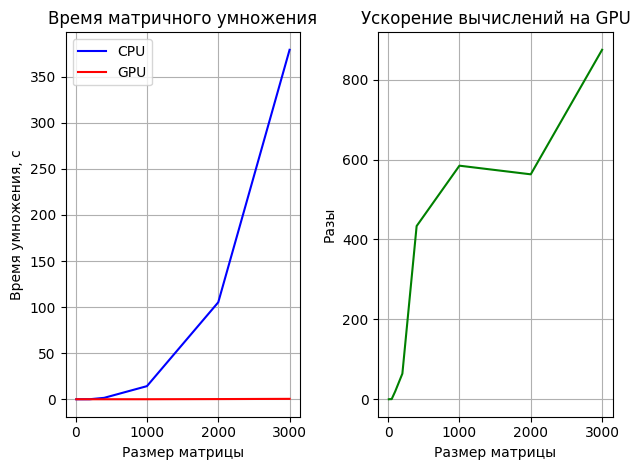

In [56]:
from matplotlib import pyplot as plt
%matplotlib inline

size = [10, 25, 50, 100, 200, 400, 1000, 2000, 3000]
gpu_time = [0.000232432, 0.000204423, 0.00264344, 0.000290221, 0.000588789, 0.00353604, 0.0243184, 0.186924, 0.433675]
cpu_time = [1.5887e-05, 7.3281e-05, 0.00096928, 0.00576776, 0.0377621, 1.5329, 14.2159, 105.23, 379.277]

assert len(size) == len(gpu_time)
assert len(size) == len(cpu_time)

acceleration = [cpu / gpu for cpu, gpu in zip(cpu_time, gpu_time)]

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].plot(size, cpu_time, label='CPU', color='b')
axes[0].plot(size, gpu_time, label='GPU', color='r')
axes[0].grid(True)
axes[0].legend()
axes[0].set_xlabel("Размер матрицы")
axes[0].set_ylabel("Время умножения, с")
axes[0].set_title('Время матричного умножения')

axes[1].plot(size, acceleration, color='g')
axes[1].grid(True)
axes[1].set_xlabel("Размер матрицы")
axes[1].set_ylabel("Разы")
axes[1].set_title('Ускорение вычислений на GPU')

plt.tight_layout()
plt.show()